# MNIST test dataset 

In [1]:
'''Trains a simple convnet on the MNIST dataset.
Gets to 99.25% test accuracy after 12 epochs
(there is still a lot of margin for parameter tuning).
16 seconds per epoch on a GRID K520 GPU.
'''

from __future__ import print_function
import keras
from keras.datasets import mnist
from keras.models import Sequential, load_model
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras import utils as np_utils
from keras import backend as K
import multiprocessing
import numpy as np
import matplotlib.pyplot as plt
from scipy.misc import imsave
import numpy as np
import time

/home/cyrilwendl/miniconda3/envs/carnd-term1/lib/python3.5/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


# Data Import 
Import the data, delete all data in the training set of class 7


In [2]:
# adapted from Source: https://github.com/keras-team/keras/tree/master/examples

# the data, shuffled and split between train and test sets
(x_train, y_train), (x_test_all, y_test_all) = mnist.load_data()
print(np.unique(y_train, return_counts=True))

label_to_remove = 7
    

# remove all trainig samples containing a label label_to_remove
x_train = x_train[y_train!=label_to_remove]
y_train = y_train[y_train!=label_to_remove]
    
x_test = x_test_all[y_test_all!=label_to_remove]
y_test = y_test_all[y_test_all!=label_to_remove]

# decrease all labels that are higher by -1 to avoid gaps
for i in range(label_to_remove+1, 11):
    y_train[y_train == i] = (i-1)
    y_test[y_test == i] = (i-1)
print(np.unique(y_train, return_counts=True))

(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=uint8), array([5923, 6742, 5958, 6131, 5842, 5421, 5918, 6265, 5851, 5949]))
(array([0, 1, 2, 3, 4, 5, 6, 7, 8], dtype=uint8), array([5923, 6742, 5958, 6131, 5842, 5421, 5918, 5851, 5949]))


In [3]:
batch_size = 128
num_classes = 9
epochs = 12 # TODO increase number of epochs

# input image dimensions
img_rows, img_cols = 28, 28

# Reshape for Tensorflow
x_train = x_train.reshape(x_train.shape[0], img_rows, img_cols, 1)
x_test = x_test.reshape(x_test.shape[0], img_rows, img_cols, 1)
x_test_all = x_test_all.reshape(x_test_all.shape[0], img_rows, img_cols, 1)
input_shape = (img_rows, img_cols, 1)

x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_test_all = x_test_all.astype('float32')
x_train /= 255
x_test /= 255
x_test_all /= 255
print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')

# convert class vectors to binary class matrices
y_train = np_utils.np_utils.to_categorical(y_train, num_classes)
y_test = np_utils.np_utils.to_categorical(y_test, num_classes)

x_train shape: (53735, 28, 28, 1)
53735 train samples
8972 test samples


In [4]:
model = Sequential()
model.add(Conv2D(32, kernel_size=(3, 3),
                 activation='relu',
                 input_shape=input_shape))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes, activation='softmax'))

model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=keras.optimizers.Adadelta(),
              metrics=['accuracy'])

print(model.summary())

model_train = True;
if model_train:
    model.fit(x_train, y_train,
          batch_size=batch_size,
          epochs=epochs,
          verbose=1,
          validation_data=(x_test, y_test))
    model.save('mnist-weights.h5')
else :
    model = load_model('mnist-weights.h5')

score = model.evaluate(x_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 26, 26, 32)        320       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 24, 24, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 12, 12, 64)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 12, 12, 64)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 9216)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 128)               1179776   
_________________________________________________________________
dropout_2 (Dropout)          (None, 128)               0         
__________

#### Make some predictions for the unseen class

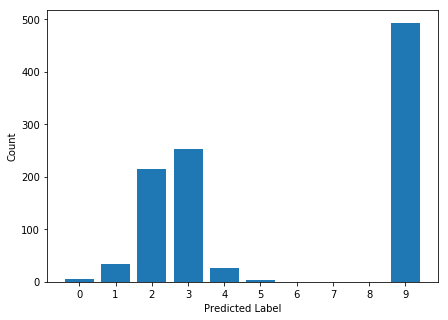

In [5]:
# all images in the test set containing a label label_to_remove
x_unseen_class = x_test_all[np.where(y_test_all==label_to_remove)[0]] 

# make prodictions for class unseen during training
y_pred = model.predict(x_unseen_class)
y_pred_label = np.argmax(y_pred, axis = 1);

for i in range(label_to_remove, 9):
    y_pred_label[y_pred_label == i] = (i+1)

# distribution of predicted label
pred_labels, pred_counts = np.unique(y_pred_label,return_counts=True)

# visualization
fig = plt.figure(figsize=(7,5))
plt.bar(pred_labels, pred_counts)
plt.xticks(np.arange(0,10))
plt.xlabel("Predicted Label")
plt.ylabel("Count")
plt.savefig("../Figures/pred-count.pdf", bbox_inches='tight', pad_inches=0)
plt.show()

In [6]:
# Avarage certitude for unseen class: 1-max_margin
c = []
for i in range(len(y_pred_label)):
    y_probas = np.sort(y_pred[i])  # probabilities for one image
    c.append(y_probas[-1]-y_probas[-2])  # margin

    
pred_acc_mean = np.mean(c)
pred_acc_std = np.std(c)
    
print("Mean accuracy: %.2f %%" % (pred_acc_mean*100) )
print("Std accuracy: %.2f %%" % (pred_acc_std*100) )

c = np.asarray(c)
pred_acc_high = .95 # 95 % is considered a very high confidence


pct = np.round(len(c[c>pred_acc_high])/len(c),4)*100
print("%.2f%% of all predictions made with an accuracy higher than %.2f%%" % (pct, pred_acc_high))

Mean accuracy: 65.30 %
Std accuracy: 32.30 %
28.02% of all predictions made with an accuracy higher than 0.95%


In [7]:
# Avarage certitude for seen class: 1-max_margin
y_pred_seen = model.predict(x_test)
y_pred_label_seen = np.argmax(y_pred_seen, axis = 1);

for i in range(label_to_remove, 9):
    y_pred_label_seen[y_pred_label_seen == i] = (i+1)

c = []
for i in range(len(y_pred_label_seen)):
    y_probas_seen = np.sort(y_pred_seen[i])  # probabilities for one image
    c.append(y_probas_seen[-1]-y_probas_seen[-2])  # margin

    
pred_acc_mean = np.mean(c)
pred_acc_std = np.std(c)
    
print("Mean accuracy: %.2f %%" % (pred_acc_mean*100) )
print("Std accuracy: %.2f %%" % (pred_acc_std*100) )

c = np.asarray(c)
pred_acc_high = .95 # 95 % is considered a very high confidence


pct = np.round(len(c[c>pred_acc_high])/len(c),4)*100
print("%.2f %% of all predictions made with an accuracy higher than %.2f%%" % (pct, pred_acc_high))

Mean accuracy: 98.67 %
Std accuracy: 8.30 %
96.38 % of all predictions made with an accuracy higher than 0.95%


# Activation weights visualization

In [8]:
# from https://github.com/keras-team/keras/issues/41

from keras import backend as K
def get_activations(model, layer, X_batch):
    get_activations = K.function([model.layers[0].input, K.learning_phase()], [model.layers[layer].output,])
    activations = get_activations([X_batch,0])
    return activations

(1, 1, 24, 24, 64)


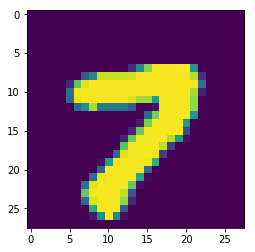

In [9]:
ind_im_test = 10
activations = get_activations(model, 1, x_unseen_class[ind_im_test][np.newaxis,:,:,:])
print(np.shape(activations))
plt.imshow(x_unseen_class[ind_im_test][:,:,0])
plt.show()

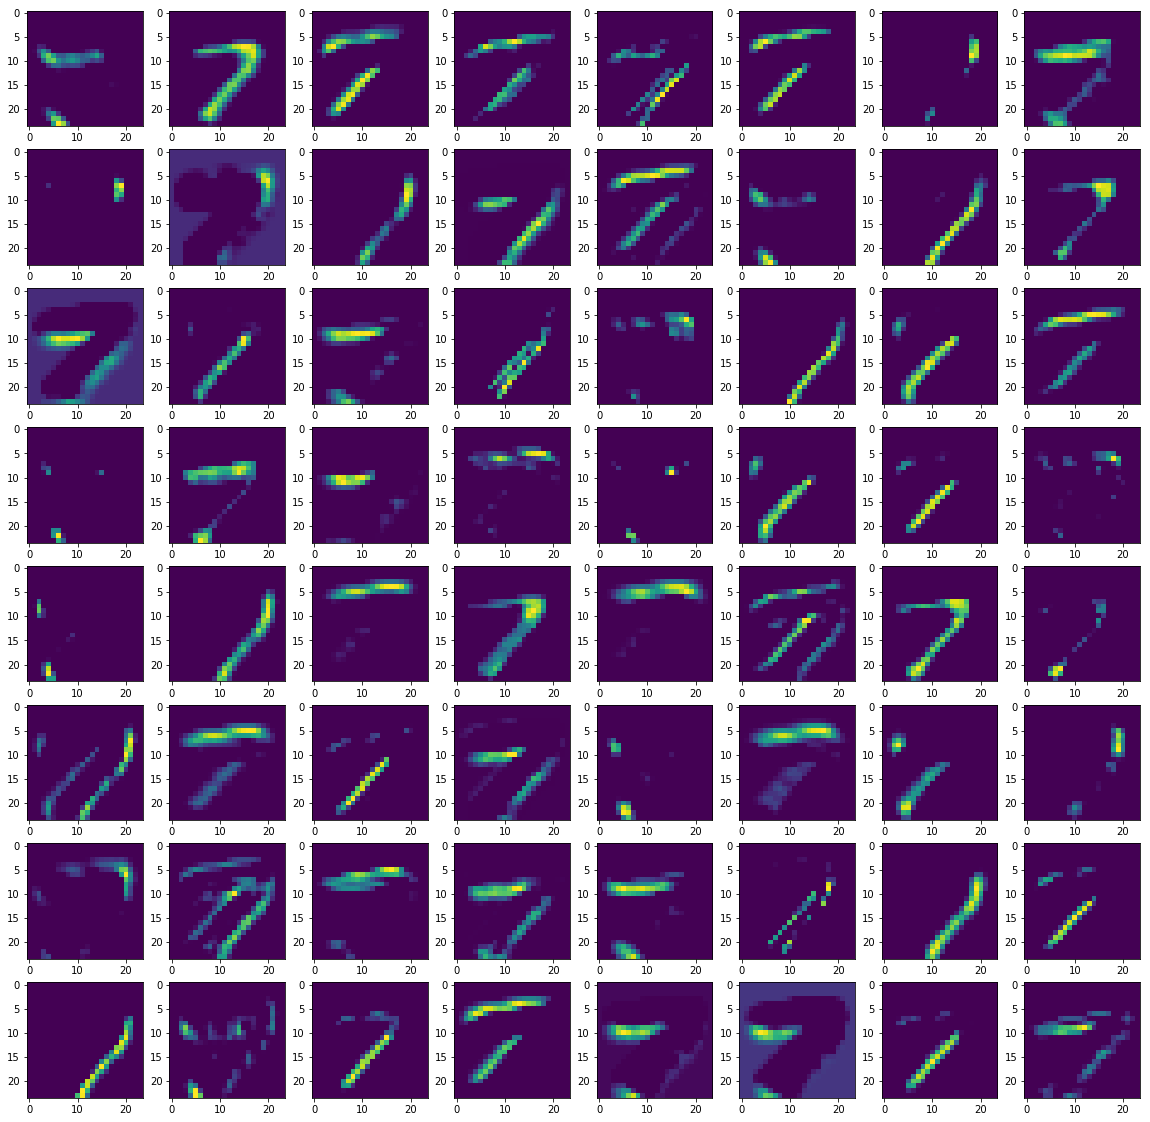

In [10]:
fig, axes = plt.subplots(8,8)
fig.set_size_inches(20,20)
for i in range(8):
    for j in range(8):
        axes[i][j].imshow(activations[0][0][:,:,i*8+j])
plt.show()

In [11]:
y_test = np.argmax(y_test, axis = 1)

In [12]:
# get activation weights of last layer
activations_unseen_class = get_activations(model, 6, x_unseen_class)[0]
print(np.shape(activations_unseen_class))

activations_seen_classes = get_activations(model, 6, x_test[:2000])[0]
print(np.shape(activations_seen_classes))

activations_all = get_activations(model, 6, x_test_all[:2000])[0]
print(np.shape(activations_seen_classes))

ResourceExhaustedError: OOM when allocating tensor with shape[1028,32,26,26]
	 [[Node: conv2d_1/convolution = Conv2D[T=DT_FLOAT, data_format="NHWC", padding="VALID", strides=[1, 1, 1, 1], use_cudnn_on_gpu=true, _device="/job:localhost/replica:0/task:0/device:GPU:0"](_arg_conv2d_1_input_0_0/_197, conv2d_1/kernel/read)]]

Caused by op 'conv2d_1/convolution', defined at:
  File "/home/cyrilwendl/miniconda3/envs/carnd-term1/lib/python3.5/runpy.py", line 184, in _run_module_as_main
    "__main__", mod_spec)
  File "/home/cyrilwendl/miniconda3/envs/carnd-term1/lib/python3.5/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/home/cyrilwendl/miniconda3/envs/carnd-term1/lib/python3.5/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/home/cyrilwendl/miniconda3/envs/carnd-term1/lib/python3.5/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/home/cyrilwendl/miniconda3/envs/carnd-term1/lib/python3.5/site-packages/ipykernel/kernelapp.py", line 486, in start
    self.io_loop.start()
  File "/home/cyrilwendl/miniconda3/envs/carnd-term1/lib/python3.5/site-packages/tornado/ioloop.py", line 888, in start
    handler_func(fd_obj, events)
  File "/home/cyrilwendl/miniconda3/envs/carnd-term1/lib/python3.5/site-packages/tornado/stack_context.py", line 277, in null_wrapper
    return fn(*args, **kwargs)
  File "/home/cyrilwendl/miniconda3/envs/carnd-term1/lib/python3.5/site-packages/zmq/eventloop/zmqstream.py", line 450, in _handle_events
    self._handle_recv()
  File "/home/cyrilwendl/miniconda3/envs/carnd-term1/lib/python3.5/site-packages/zmq/eventloop/zmqstream.py", line 480, in _handle_recv
    self._run_callback(callback, msg)
  File "/home/cyrilwendl/miniconda3/envs/carnd-term1/lib/python3.5/site-packages/zmq/eventloop/zmqstream.py", line 432, in _run_callback
    callback(*args, **kwargs)
  File "/home/cyrilwendl/miniconda3/envs/carnd-term1/lib/python3.5/site-packages/tornado/stack_context.py", line 277, in null_wrapper
    return fn(*args, **kwargs)
  File "/home/cyrilwendl/miniconda3/envs/carnd-term1/lib/python3.5/site-packages/ipykernel/kernelbase.py", line 283, in dispatcher
    return self.dispatch_shell(stream, msg)
  File "/home/cyrilwendl/miniconda3/envs/carnd-term1/lib/python3.5/site-packages/ipykernel/kernelbase.py", line 233, in dispatch_shell
    handler(stream, idents, msg)
  File "/home/cyrilwendl/miniconda3/envs/carnd-term1/lib/python3.5/site-packages/ipykernel/kernelbase.py", line 399, in execute_request
    user_expressions, allow_stdin)
  File "/home/cyrilwendl/miniconda3/envs/carnd-term1/lib/python3.5/site-packages/ipykernel/ipkernel.py", line 208, in do_execute
    res = shell.run_cell(code, store_history=store_history, silent=silent)
  File "/home/cyrilwendl/miniconda3/envs/carnd-term1/lib/python3.5/site-packages/ipykernel/zmqshell.py", line 537, in run_cell
    return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
  File "/home/cyrilwendl/miniconda3/envs/carnd-term1/lib/python3.5/site-packages/IPython/core/interactiveshell.py", line 2728, in run_cell
    interactivity=interactivity, compiler=compiler, result=result)
  File "/home/cyrilwendl/miniconda3/envs/carnd-term1/lib/python3.5/site-packages/IPython/core/interactiveshell.py", line 2850, in run_ast_nodes
    if self.run_code(code, result):
  File "/home/cyrilwendl/miniconda3/envs/carnd-term1/lib/python3.5/site-packages/IPython/core/interactiveshell.py", line 2910, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-4-97ec3d3132dc>", line 4, in <module>
    input_shape=input_shape))
  File "/home/cyrilwendl/miniconda3/envs/carnd-term1/lib/python3.5/site-packages/keras/models.py", line 464, in add
    layer(x)
  File "/home/cyrilwendl/miniconda3/envs/carnd-term1/lib/python3.5/site-packages/keras/engine/topology.py", line 603, in __call__
    output = self.call(inputs, **kwargs)
  File "/home/cyrilwendl/miniconda3/envs/carnd-term1/lib/python3.5/site-packages/keras/layers/convolutional.py", line 164, in call
    dilation_rate=self.dilation_rate)
  File "/home/cyrilwendl/miniconda3/envs/carnd-term1/lib/python3.5/site-packages/keras/backend/tensorflow_backend.py", line 3189, in conv2d
    data_format=tf_data_format)
  File "/home/cyrilwendl/miniconda3/envs/carnd-term1/lib/python3.5/site-packages/tensorflow/python/ops/nn_ops.py", line 751, in convolution
    return op(input, filter)
  File "/home/cyrilwendl/miniconda3/envs/carnd-term1/lib/python3.5/site-packages/tensorflow/python/ops/nn_ops.py", line 835, in __call__
    return self.conv_op(inp, filter)
  File "/home/cyrilwendl/miniconda3/envs/carnd-term1/lib/python3.5/site-packages/tensorflow/python/ops/nn_ops.py", line 499, in __call__
    return self.call(inp, filter)
  File "/home/cyrilwendl/miniconda3/envs/carnd-term1/lib/python3.5/site-packages/tensorflow/python/ops/nn_ops.py", line 187, in __call__
    name=self.name)
  File "/home/cyrilwendl/miniconda3/envs/carnd-term1/lib/python3.5/site-packages/tensorflow/python/ops/gen_nn_ops.py", line 631, in conv2d
    data_format=data_format, name=name)
  File "/home/cyrilwendl/miniconda3/envs/carnd-term1/lib/python3.5/site-packages/tensorflow/python/framework/op_def_library.py", line 787, in _apply_op_helper
    op_def=op_def)
  File "/home/cyrilwendl/miniconda3/envs/carnd-term1/lib/python3.5/site-packages/tensorflow/python/framework/ops.py", line 2956, in create_op
    op_def=op_def)
  File "/home/cyrilwendl/miniconda3/envs/carnd-term1/lib/python3.5/site-packages/tensorflow/python/framework/ops.py", line 1470, in __init__
    self._traceback = self._graph._extract_stack()  # pylint: disable=protected-access

ResourceExhaustedError (see above for traceback): OOM when allocating tensor with shape[1028,32,26,26]
	 [[Node: conv2d_1/convolution = Conv2D[T=DT_FLOAT, data_format="NHWC", padding="VALID", strides=[1, 1, 1, 1], use_cudnn_on_gpu=true, _device="/job:localhost/replica:0/task:0/device:GPU:0"](_arg_conv2d_1_input_0_0/_197, conv2d_1/kernel/read)]]


# Density Tree
Feed activation weigths into density tree

In [ ]:
from density_tree.density_forest import *
from density_tree.density_tree_create import *
from density_tree.density_tree_traverse import *
from density_tree.create_data import *
from density_tree.helpers import *
from density_tree.plots import *
from sklearn import decomposition
import warnings

In [ ]:
# create density tree for activation weights of training data

dimensions = activations_seen_classes.shape[1]
nclusters = 9

# PCA
n_components = 30
plt.cla()
pca = decomposition.PCA(n_components=n_components)
pca.fit(activations_seen_classes)
print("Explained variance ratio by first components:")
print(pca.explained_variance_ratio_)  
print("Variance explained by first %i components: %.2f" % (n_components, np.sum(pca.explained_variance_ratio_[:n_components])))
plt.scatter(np.arange(n_components), np.cumsum(pca.explained_variance_ratio_))
plt.xlabel("Number of components")
plt.ylabel("Cumulative sum of explained variance")
plt.grid()
plt.savefig("../Figures/pca_components.pdf", bbox_inches='tight', pad_inches=0)
plt.show()

In [ ]:
X_all = pca.transform(activations_all)
X_seen = pca.transform(activations_seen_classes)
X_unseen = pca.transform(activations_unseen_class)

warnings.filterwarnings("ignore")
root = create_density_tree(X_seen, dimensions = dimensions, clusters = nclusters)

Next, we can plot the first three components to of the reduced data to search for clusters:

In [ ]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(X_seen[:,0], X_seen[:,1], zs=X_seen[:,2], c=y_test[:2000], cmap=plt.get_cmap('rainbow'), s=20)
ax.scatter(X_unseen[:,0], X_unseen[:,1], zs=X_unseen[:,2], c='black', s=30, marker='x', depthshade=False) 
ax.legend(['seen classes','unseen class'])

plt.savefig("../Figures/pca_components_3d.pdf", bbox_inches='tight', pad_inches=0)
plt.show()
print("Variance explained by first 3 components: %.2f" % np.sum(pca.explained_variance_ratio_[:3]))

Since only 54% of the variance is explained in the first 3 components the clusters are hard to discern.

In [ ]:
root_nodes_seen = density_forest_create(X_seen, dimensions, nclusters, 500, .3, -1)

probas_seen = density_forest_traverse(X_seen, root_nodes_seen)
probas_seen = probas_seen[np.isnan(probas_seen)==False] # only keep non-NaN values

In [ ]:
probas_unseen = density_forest_traverse(X_unseen, root_nodes_seen)
probas_unseen = probas_unseen[np.isnan(probas_unseen)==False] # only keep non-NaN values

In [ ]:
mean_proba_seen = np.mean(probas_seen)
mean_proba_unseen = np.mean(probas_unseen)

std_proba_seen = np.std(probas_seen)
std_proba_unseen = np.std(probas_unseen)

In [ ]:
mean_proba_unseen

In [ ]:
print("Mean probability of unseen class to belong to clusters: %.2f " % (mean_proba_unseen * 1e22))
print("Std probability of unseen class to belong to clusters: %.2f " % (std_proba_unseen * 1e22))

print("Mean probability of seen classes to belong to clusters: %.2f " % (mean_proba_seen * 1e22))
print("Std probability of seen classes to belong to clusters: %.2f " % (std_proba_seen * 1e22))

In [ ]:
print("Ratio unseen / seen: %.2f" % (mean_proba_unseen/mean_proba_seen))
print("Ratio seen / unseen: %.2f" % (mean_proba_seen/mean_proba_unseen))